![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 4 - Deep Learning Basics</center>
### <center> Stochastic Gradient Descent (SGD)</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/04_OptimizationMethods/Backpropagation.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

np.random.seed(1)

In [3]:
#-- What we have so far:
from DeepAuxiliary import *

### Get Fashion MNIST dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

oTorchTrainSet = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transforms.ToTensor())
# oTorchTestSet  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTorchTrainSet.classes
mX       = oTorchTrainSet.data.view(-1,784).numpy() / 255
vY       = oTorchTrainSet.targets.numpy()
lClasses

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

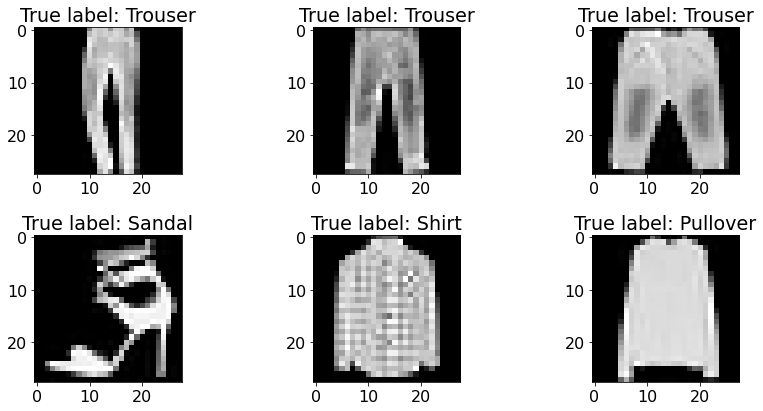

In [5]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(12,6))
for ax in fig.axes:
    idx = np.random.randint(0, N)
    ax.imshow(np.reshape(mX[idx,:], (28, 28)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[vY[idx]]))
    
plt.tight_layout()
plt.show()

###  Normalize data:

In [6]:
vMean = np.mean(mX, axis=0)
vStd  = np.std(mX, axis=0)
mX    = (mX - vMean) / vStd

###  Split to train and validation:

In [7]:
from sklearn.model_selection import train_test_split

Ntrain = 55000
Nval   = 5000
mTrainX, mValX, vTrainY, vValY = train_test_split(mX, vY, train_size=Ntrain, test_size=Nval)

(mTrainX.shape, 
vTrainY.shape, 
mValX.shape,  
vValY.shape)

((55000, 784), (55000,), (5000, 784), (5000,))

### Define a data loader class:

In [8]:
class DataSet:
    def __init__(self, mX, vY, batchSize):
        self.mX             = mX
        self.vY             = vY
        self.N              = len(vY)
        self.batchSize      = min(batchSize, self.N)
        self.numMiniBatches = self.N // self.batchSize
            
    def __len__(self):
        return self.numMiniBatches
    
    def __iter__(self):
        self.vIdx = np.random.permutation(self.N)
        self.ii   = 0
        
        return self
        
    def __next__(self):
        if self.ii < self.numMiniBatches:
            startIdx  = self.ii * self.batchSize
            vBatchIdx = self.vIdx[startIdx : startIdx + self.batchSize]
            mBatchX   = self.mX[:,vBatchIdx]
            vBatchY   = self.vY[vBatchIdx]
            self.ii  += 1

            return mBatchX, vBatchY
        else:
            raise StopIteration

### Construct train and validation data loaders:

In [9]:
batchSize = 8192
oTrainSet = DataSet(mTrainX.T, vTrainY, batchSize)
oValSet   = DataSet(mValX.T,   vValY,  batchSize)

### Define the training loop with mini-batches:

In [10]:
import time

def Accuracy(mHatY, vY):
    vHatY    = np.argmax(mHatY, axis=0)
    accuracy = (vHatY == vY).astype(float).mean()
    return accuracy
    
def TrainLoop(oModel, oTrainData, learningRate):
    
    epochLoss = 0
    epochAcc  = 0
    for ii, (mX, vY) in enumerate(oTrainData):
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (vanilla gradient descnet)
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]
                
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
        print(f'Iteration: {ii:3d}: loss = {loss:.6f}\r', end='')
    
    epochLoss /= ii + 1
    epochAcc  /= ii + 1
    
    return epochLoss, epochAcc

def ValidationLoop(oModel, oValData):
    
    epochLoss = 0
    epochAcc  = 0
    for ii, (mX, vY) in enumerate(oValData):
        #-- Forward:
        mZ      = oModel.Forward(mX)
        loss, _ = CrossEntropyLoss(vY, mZ)
               
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
    
    epochLoss /= ii + 1
    epochAcc  /= ii + 1
    
    return epochLoss, epochAcc

In [11]:
def TrainModel(oModel, oTrainData, oValData, numEpochs, learningRate):
    for epoch in range(numEpochs):
        startTime           = time.time()
        #-- Train:
        trainLoss, trainAcc = TrainLoop(oModel, oTrainData, learningRate)
        #-- Validation:
        valLoss,   valAcc   = ValidationLoop(oModel, oValData)
        endTime             = time.time()

        print('Epoch '              f'{epoch:3d}:',     end='')
        print(' | Train loss: '     f'{trainLoss:.5f}', end='')
        print(' | Val loss: '       f'{valLoss:.5f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}', end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',   end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')


### Train a shallow model:

In [12]:
oModel = Model([
        LinearLayer(784, 200),
        ReLULayer(),
        LinearLayer(200, 10),
])

TrainModel(oModel, oTrainSet, oValSet, 10, 5e-2)

Epoch   0: | Train loss: 1.74713 | Val loss: 1.07564 | Train Accuracy: 0.4385 | Val Accuracy: 0.6436 | epoch time: 1.090 |
Epoch   1: | Train loss: 0.97749 | Val loss: 0.86799 | Train Accuracy: 0.6724 | Val Accuracy: 0.7088 | epoch time: 1.080 |
Epoch   2: | Train loss: 0.82482 | Val loss: 0.77569 | Train Accuracy: 0.7206 | Val Accuracy: 0.7336 | epoch time: 1.091 |
Epoch   3: | Train loss: 0.74882 | Val loss: 0.72019 | Train Accuracy: 0.7456 | Val Accuracy: 0.7524 | epoch time: 1.176 |
Epoch   4: | Train loss: 0.69764 | Val loss: 0.68011 | Train Accuracy: 0.7621 | Val Accuracy: 0.7658 | epoch time: 1.171 |
Epoch   5: | Train loss: 0.66304 | Val loss: 0.65008 | Train Accuracy: 0.7735 | Val Accuracy: 0.7784 | epoch time: 1.138 |
Epoch   6: | Train loss: 0.63455 | Val loss: 0.62603 | Train Accuracy: 0.7817 | Val Accuracy: 0.7848 | epoch time: 1.168 |
Epoch   7: | Train loss: 0.61467 | Val loss: 0.60613 | Train Accuracy: 0.7879 | Val Accuracy: 0.7914 | epoch time: 1.153 |
Epoch   8: | Tra

### Add figures to training loop:

In [13]:
class Plot:
    def __init__(self, sTitle, sLabel, sXlabel, sColor, vData=[]):
        self.sTitle  = sTitle
        self.sLabel  = sLabel
        self.sXlabel = sXlabel
        self.sColor  = sColor
        self.vData   = vData

class Recorder:
    def __init__(self, lPlots, figsize=(12,4)):
        self.lTitles = np.unique([oPlot.sTitle for oPlot in lPlots])
        self.N       = len(self.lTitles)
        self.fig, _  = plt.subplots(1, self.N, figsize=(12, 4))
        self.dAxes   = {}
        ii           = 0
        for oPlot in lPlots:
            ax = self.dAxes.get(oPlot.sTitle, None)            
            if ax == None:
                ax                       = self.fig.axes[ii]
                ii                      += 1
                self.dAxes[oPlot.sTitle] = ax
            
            ax.set_title(oPlot.sTitle)
            ax.set_xlabel(oPlot.sXlabel)
            ax.plot(oPlot.vData, c=oPlot.sColor, label=oPlot.sLabel)
            ax.legend()
            ax.grid(True)        
        
        plt.tight_layout()
        
    def Append(self, sTitle, sLabel, vData):
        ax = self.dAxes[sTitle]
        for oLine in ax.lines:
            if oLine.get_label() == sLabel:
                vYdata = np.append(oLine.get_ydata(), vData)
                N      = len(vYdata)       
                oLine.set_data(list(range(N)), vYdata)
        lYlim = ax.axis()[2:4]
        ax.axis(xmin=0, xmax=N, ymin=np.minimum(np.min(vData), lYlim[0]), ymax=np.maximum(np.max(vData), lYlim[1]))
                
    def Draw(self):
        self.fig.canvas.draw()
        plt.pause(1e-10)
            

In [14]:
def TrainLoop(oModel, oTrainData, learningRate, oRecorder=None):
    
    epochLoss = 0
    epochAcc  = 0
    for ii, (mX, vY) in enumerate(oTrainData):
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (vanilla gradient descnet)
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]
                       
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
        print(f'Iteration: {ii:3d}: loss = {loss:.6f}\r', end='')
    
    epochLoss /= ii + 1
    epochAcc  /= ii + 1
    
    return epochLoss, epochAcc

In [15]:
def TrainModel(oModel, oTrainData, oValData, numEpochs, learningRate):
   
    oRecorder = Recorder([
        Plot('Loss',       'train', 'epoch', 'b'),
        Plot('Loss',       'val',   'epoch', 'r'),
        Plot('Accuracy',   'train', 'epoch', 'b'),
        Plot('Accuracy',   'val',   'epoch', 'r'),
    ])

    for epoch in range(numEpochs):
        startTime           = time.time()
        #-- Train:
        trainLoss, trainAcc = TrainLoop(oModel, oTrainData, learningRate)
        #-- Validation:
        valLoss,   valAcc   = ValidationLoop(oModel, oValData)
        endTime             = time.time()

        #-- Display:
        oRecorder.Append('Loss',     'train', trainLoss),
        oRecorder.Append('Loss',     'val',   valLoss),
        oRecorder.Append('Accuracy', 'train', trainAcc),
        oRecorder.Append('Accuracy', 'val',   valAcc),
        oRecorder.Draw()
        
        print('Epoch '              f'{epoch:3d}:',     end='')
        print(' | Train loss: '     f'{trainLoss:.5f}', end='')
        print(' | Val loss: '       f'{valLoss:.5f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}', end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',   end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')
        

<IPython.core.display.Javascript object>


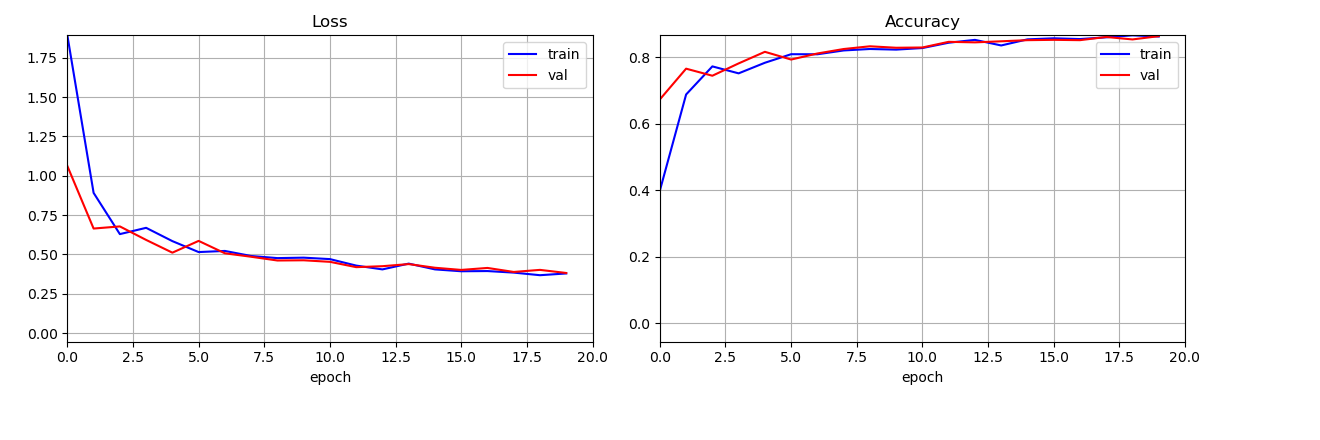

Epoch   0: | Train loss: 1.89303 | Val loss: 1.06235 | Train Accuracy: 0.3987 | Val Accuracy: 0.6726 | epoch time: 3.581 |
Epoch   1: | Train loss: 0.89139 | Val loss: 0.66458 | Train Accuracy: 0.6874 | Val Accuracy: 0.7650 | epoch time: 3.635 |
Epoch   2: | Train loss: 0.62916 | Val loss: 0.67808 | Train Accuracy: 0.7719 | Val Accuracy: 0.7438 | epoch time: 3.714 |
Epoch   3: | Train loss: 0.66917 | Val loss: 0.59229 | Train Accuracy: 0.7509 | Val Accuracy: 0.7808 | epoch time: 3.635 |
Epoch   4: | Train loss: 0.58462 | Val loss: 0.51123 | Train Accuracy: 0.7827 | Val Accuracy: 0.8156 | epoch time: 3.572 |
Epoch   5: | Train loss: 0.51504 | Val loss: 0.58607 | Train Accuracy: 0.8084 | Val Accuracy: 0.7924 | epoch time: 3.639 |
Epoch   6: | Train loss: 0.52224 | Val loss: 0.50727 | Train Accuracy: 0.8082 | Val Accuracy: 0.8106 | epoch time: 3.719 |
Epoch   7: | Train loss: 0.48998 | Val loss: 0.48522 | Train Accuracy: 0.8197 | Val Accuracy: 0.8240 | epoch time: 3.576 |
Epoch   8: | Tra

In [16]:
%matplotlib notebook

oModel = Model([
        LinearLayer(784, 500),
        ReLULayer(),
        LinearLayer(500, 250),
        ReLULayer(),
        LinearLayer(250, 150),
        ReLULayer(),
        LinearLayer(150, 100),
        ReLULayer(),
        LinearLayer(100,  10),
])

TrainModel(oModel, oTrainSet, oValSet, 20, 2e-1)

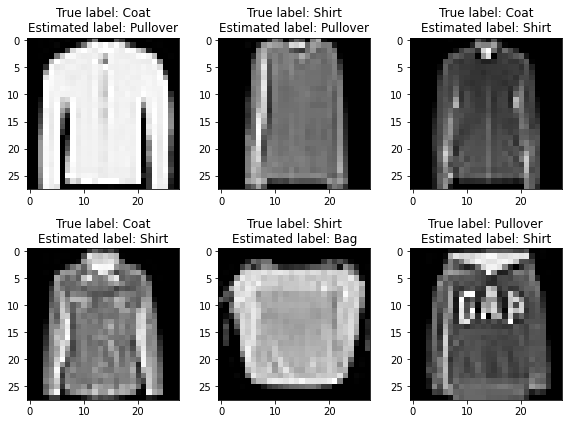

In [17]:
%matplotlib inline

oTorchTestSet = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

mTestX   = oTorchTestSet.data.view(-1,784).numpy() / 255
mTestX   = (mTestX - vMean) / vStd
vTestY   = oTorchTestSet.targets.numpy()

#-- Apply model to data:
mHatTestY  = oModel.Forward(mTestX.T)
vHatTestY  = np.argmax(mHatTestY, axis=0)

vWrongIdx = np.nonzero(vTestY != vHatTestY)[0]

#-- Plot a few mistakes:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(8,6))
for ax in fig.axes:
    idx = vWrongIdx[np.random.randint(0, len(vWrongIdx))]
    ax.imshow(np.reshape(mTestX[idx,:] * vStd + vMean, (28, 28)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[vTestY[idx]]) + '\nEstimated label: ' + str(lClasses[vHatTestY[idx]]))
    
plt.tight_layout()
plt.show()